In [1]:
# Working through the tutorial from
# http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.ion() # interactive mode

In [6]:
landmarks_frame = pd.read_csv("../../data/faces/faces/face_landmarks.csv")

In [7]:
landmarks_frame.shape

(69, 137)

In [8]:
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [10]:
n = 65
img_name = landmarks_frame.ix[n, 0]
img_name

'person-7.jpg'

In [24]:
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype("float")

In [25]:
landmarks

array([  32.,   65.,   33.,   76.,   34.,   86.,   34.,   97.,   37.,
        107.,   41.,  116.,   50.,  122.,   61.,  126.,   72.,  127.,
         83.,  126.,   95.,  123.,  107.,  119.,  115.,  111.,  118.,
        101.,  120.,   91.,  122.,   80.,  122.,   68.,   39.,   52.,
         45.,   46.,   53.,   44.,   61.,   46.,   68.,   49.,   82.,
         49.,   90.,   45.,   98.,   44.,  106.,   46.,  112.,   52.,
         74.,   57.,   74.,   63.,   74.,   69.,   74.,   75.,   67.,
         83.,   70.,   84.,   74.,   85.,   78.,   84.,   82.,   83.,
         47.,   61.,   51.,   57.,   58.,   57.,   63.,   61.,   57.,
         63.,   51.,   63.,   87.,   62.,   93.,   58.,   98.,   58.,
        103.,   61.,   99.,   63.,   93.,   63.,   55.,   98.,   63.,
         96.,   70.,   94.,   75.,   95.,   80.,   94.,   86.,   95.,
         94.,   99.,   86.,  103.,   79.,  105.,   74.,  105.,   69.,
        105.,   62.,  103.,   58.,   99.,   70.,   98.,   74.,   98.,
         79.,   98.,

In [26]:
landmarks = landmarks.reshape(-1,2)

In [27]:
landmarks[:4]

array([[ 32.,  65.],
       [ 33.,  76.],
       [ 34.,  86.],
       [ 34.,  97.]])

In [28]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, marker = ".", c = "r")
    plt.pause(0.001)

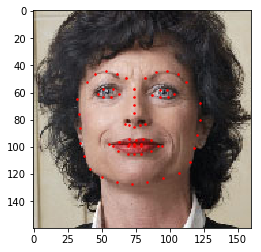

In [29]:
plt.figure()
show_landmarks(io.imread(os.path.join("../../data/faces/faces/", img_name)), landmarks)
plt.show()

In [43]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.landmarks_frame = pd.read_csv(os.path.join(csv_file))
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        image_name = self.landmarks_frame.ix[idx,0]
        image = io.imread(os.path.join(self.root_dir, image_name))
        landmarks = self.landmarks_frame.ix[idx,1:].as_matrix().astype("float")
        landmarks = landmarks.reshape(-1, 2)
        sample = {"image" : image, "landmarks" : landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [44]:
face_dataset = FaceLandmarksDataset(csv_file = "../../data/faces/faces/face_landmarks.csv",
                                    root_dir = "../../data/faces/faces/"
                                   )

In [41]:
len(face_dataset)

69

0 (324, 215, 3) (68, 2)


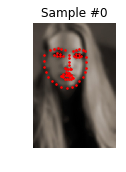

1 (500, 333, 3) (68, 2)


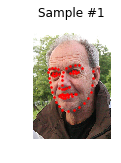

2 (250, 258, 3) (68, 2)


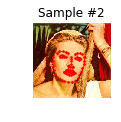

3 (434, 290, 3) (68, 2)


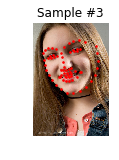

In [52]:
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample["image"].shape, sample["landmarks"].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

In [70]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                h_new, w_new = h * self.output_size / w, self.output_size
            else:
                h_new, w_new = self.output_size, w * self.output_size / h
        else:
            h_new, w_new = self.output_size
        
        h_new, w_new = int(h_new), int(w_new)
        
        img = transform.resize(image, (h_new, w_new))
        
        landmarks = landmarks * [w_new / w, h_new / h]
        
        return {"image":img, "landmarks":landmarks}

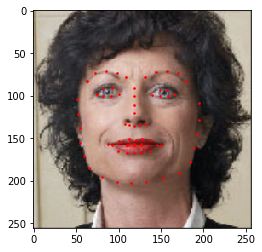

In [102]:
scale = Rescale(256)
show_landmarks(**scale(face_dataset[65]))

In [85]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int) == 1:
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
        
    def __call__(self, sample):
        
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[:2]
        h_new, w_new = self.output_size
        
        top = np.random.randint(0, h - h_new)
        left = np.random.randint(0, w - w_new)
        
        image = image[top:top+h_new, left:left+w_new]
        
        landmarks = landmarks - [left, top]
        
        return {"image":image, "landmarks":landmarks}      

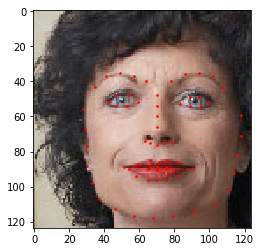

In [92]:
crop = RandomCrop(124)
show_landmarks(**crop(face_dataset[65]))

In [87]:
face_dataset[65]["image"].shape

(160, 160, 3)

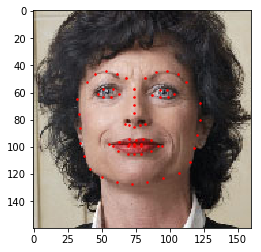

In [94]:
show_landmarks(**face_dataset[65])

In [103]:
class toTensor(object):
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image), "landmarks": torch.from_numpy(landmarks)}

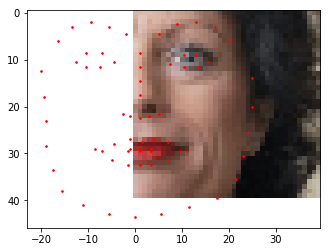

In [108]:
composed = transforms.Compose([Rescale(80), RandomCrop(40)])
show_landmarks(**composed(face_dataset[65]))

In [110]:
transformed_dataset = FaceLandmarksDataset(csv_file = "../../data/faces/faces/face_landmarks.csv", 
                                           root_dir = "../../data/faces/faces/",
                                           transform = transforms.Compose([Rescale(256), RandomCrop(224), toTensor()])
                                          )

In [117]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["landmarks"].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
